# 1.2.0 Heatmap Papers

In [1]:
import pandas as pd
import requests
from glob import glob
import json
from copy import deepcopy

In [2]:
from clustergrammer2 import net

In [3]:
all_files = glob('../markdown_files/*.md')
len(all_files)

88

### Load Altmetric Data

In [4]:
dict_altmetric = net.load_json_to_dict('../altmetric_data/altmetric_scores.json')

### Download Latest Preprints

In [5]:
url = 'https://connect.biorxiv.org/relate/collection_json.php?grp=181'

In [6]:
r = requests.get(url)

In [7]:
req_dict = json.loads(r.text)

In [8]:
stop_words = ["i","me","my","myself","we","us","our","ours","ourselves","you","your","yours","yourself","yourselves","he","him","his","himself","she","her","hers","herself","it","its","itself","they","them","their","theirs","themselves","what","which","who","whom","whose","this","that","these","those","am","is","are","was","were","be","been","being","have","has","had","having","do","does","did","doing","will","would","should","can","could","ought","i'm","you're","he's","she's","it's","we're","they're","i've","you've","we've","they've","i'd","you'd","he'd","she'd","we'd","they'd","i'll","you'll","he'll","she'll","we'll","they'll","isn't","aren't","wasn't","weren't","hasn't","haven't","hadn't","doesn't","don't","didn't","won't","wouldn't","shan't","shouldn't","can't","cannot","couldn't","mustn't","let's","that's","who's","what's","here's","there's","when's","where's","why's","how's","a","an","the","and","but","if","or","because","as","until","while","of","at","by","for","with","about","against","between","into","through","during","before","after","above","below","to","from","up","upon","down","in","out","on","off","over","under","again","further","then","once","here","there","when","where","why","how","all","any","both","each","few","more","most","other","some","such","no","nor","not","only","own","same","so","than","too","very","say","says","said","shall","2019","novel","patients","using","may","2019-ncov","2020"]
stop_words.extend(['2020,', 'conclusions', 'characteristics'])

In [9]:
doi_words = {}
all_words = []
doi_titles = {}
arr_papers = req_dict['rels']
for inst_paper in arr_papers:

    # get words from abstract
    inst_words = [x.lower().replace(':','').replace(',','').replace('.','')
                           .replace('(', '').replace(')', '')
                           .replace('\n','').replace('\t','')
                           for x in inst_paper['rel_abs'].split()]
    
    inst_words = [x for x in inst_words if x not in stop_words]    
    
    # save words to dict 
    doi_words[inst_paper['rel_doi']] = sorted(list(set(inst_words)))
    
    doi_titles[inst_paper['rel_doi']] = inst_paper['rel_title']
    
    all_words.extend(inst_words)

In [10]:
ser_titles = pd.Series(doi_titles)
ser_titles.head()

10.1101/2020.04.02.022194    Structural basis of RNA recognition by the SAR...
10.1101/2020.04.04.025080    Computational analysis suggests putative inter...
10.1101/2020.04.01.020594    A snapshot of SARS-CoV-2 genome availability u...
10.1101/2020.04.03.023887     Topological Analysis of SARS CoV-2 Main Protease
10.1101/2020.04.02.022186    Analytical Validation of a COVID-19 qRT-PCR De...
dtype: object

In [11]:
df_meta = pd.DataFrame(ser_titles, columns=['Title'])
df_meta.shape

(1165, 1)

### Add Paper Metadata

In [12]:
inst_paper.keys()

dict_keys(['rel_title', 'rel_doi', 'rel_link', 'rel_abs', 'rel_authors', 'rel_date', 'rel_site'])

In [13]:
for inst_paper in arr_papers:
    inst_doi = inst_paper['rel_doi']
    
    # date
    inst_date = inst_paper['rel_date'].split('-')
    df_meta.loc[inst_doi, 'date'] = float( inst_date[1] + '.' + inst_date[2])
    
    # altmetric score
    if inst_doi in dict_altmetric:
        df_meta.loc[inst_doi, 'altmetric'] = dict_altmetric[inst_doi]
    else:
        print('not found')
        df_meta.loc[inst_doi, 'altmetric'] = 0

not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


In [14]:
ser_count = pd.Series(all_words).value_counts()
ser_count = ser_count[ser_count < len(arr_papers) * 0.75 ][ser_count > 5]
ser_count.shape

(3435,)

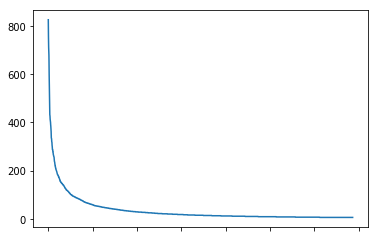

In [15]:
ser_count.plot()

In [16]:
top_words = ser_count.index.tolist()[:1000]

In [17]:
all_dois = sorted(list(doi_words.keys()))
len(all_dois)

1165

In [18]:
df_words = pd.DataFrame(0, index=top_words, columns=all_dois)

In [19]:
for inst_doi in all_dois:
    inst_words = list(set(doi_words[inst_doi]).intersection(top_words))
    df_words.loc[inst_words, inst_doi] = 1

### Add Column Categories

In [20]:
cols = df_words.columns.tolist()
new_cols = [(df_meta.loc[x, 'Title'][:50], 'Date: ' + str(df_meta.loc[x, 'date']), 'Altmetric: ' + str(df_meta.loc[x, 'altmetric']) )  for x in cols]
df_cat = deepcopy(df_words)
df_cat.columns = new_cols

In [21]:
net.load_df(df_cat)
# net.cluster(dist_type='jaccard')
net.widget()

ExampleWidget(network='{"row_nodes": [{"name": "data", "ini": 1000, "clust": 996, "rank": 998, "rankvar": 998,…

### Words and Reviews

In [22]:
# words_list = []
# for inst_file in all_files:
#     f = open(inst_file, 'r')
#     lines = f.readlines()
#     f.close()
    
#     for inst_line in lines:
#         inst_line = inst_line.lower()
            
#         inst_words = inst_line.split(' ')
#         inst_words = [x for x in inst_words if '*' not in x]
#         words_list.extend(inst_words)

In [23]:
# pd.Series(words_list).value_counts().head(50)